In this notebook we will generate C code and use CVode from the sundials suite to integrate the system of differential equations. Sundials is a well established and well tested open-source BSD-licensed library with excellent documentation. [Here is the documentation for CVode](https://computation.llnl.gov/sites/default/files/public/cv_guide.pdf).

We will use a thin Cython wrapper which calls the integration routine and returns the solution as a numpy vector and a dictionary, along with information about the integration.

In [1]:
import json
import numpy as np
from scipy2017codegen.odesys import ODEsys
from scipy2017codegen.chem import mk_rsys

Again, using the `ODEsys` convenience class from notebook "35":

In [2]:
watrad_data = json.load(open('../scipy2017codegen/data/radiolysis_300_Gy_s.json'))
watrad = mk_rsys(ODEsys, **watrad_data)
tout = np.logspace(-6, 3, 200)  # close to one hour of operation
c0 = {'H2O': 55.4e3, 'H+': 1e-4, 'OH-': 1e-4}
y0 = [c0.get(symb.name, 0) for symb in watrad.y]

In [3]:
%timeit yout, info = watrad.integrate_odeint(tout, y0)

The slowest run took 4.74 times longer than the fastest. This could mean that an intermediate result is being cached.
239 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


that is still the benchmark to beat. Subclassing `ODEsys` to have it render, compile and import the code:

In [4]:
# %load ../scipy2017codegen/odesys_cvode.py
import os
import sys
import uuid
import sympy as sym
import setuptools
import numpy as np
import setuptools
import pyximport
from scipy2017codegen import templates
from scipy2017codegen.odesys import ODEsys

pyximport.install()

kw = {
    'sources': [],
    'include_dirs': [os.getcwd(), np.get_include()],
    'libraries': ['sundials_cvode', 'sundials_nvecserial'],
    'library_dirs': [],
    'extra_compile_args': [],
    'extra_link_args': []
}

osx = sys.platform.lower() == 'darwin'
win = os.name == 'nt'
posix = os.name == 'posix'

if not win:
    kw['libraries'] += ['m']

if posix:
    kw['libraries'] += ['openblas']


class ODEcvode(ODEsys):

    default_integrator = 'cvode'

    def setup(self):
        self.uid = uuid.uuid4().hex[:10]
        self.mod_name = 'ode_c_%s' % self.uid
        idxs = list(range(len(self.f)))
        subs = {s: sym.Symbol('y[%d]' % i) for i, s in enumerate(self.y)}
        f_exprs = ['out[%d] = %s;' % (i, sym.ccode(self.f[i].xreplace(subs)))
                   for i in idxs]
        j_col_defs = ['realtype * const col_%d = DENSE_COL(J, %d);' % (ci, ci)
                      for ci in idxs]
        j_exprs = ['col_%d[%d] = %s;' % (ci, ri, self.j[ri, ci].xreplace(subs))
                   for ci in idxs for ri in idxs if self.j[ri, ci] != 0]
        ctx = dict(
            func = '\n    '.join(f_exprs + ['return 0;']),
            dense_jac = '\n    '.join(j_col_defs + j_exprs + ['return 0;']),
            band_jac = 'return -1;'
        )
        open('integrate_serial_%s.c' % self.uid, 'wt').write(templates.sundials['integrate_serial.c'] % ctx)
        open('%s.pyx' % self.mod_name, 'wt').write(templates.sundials['_integrate_serial.pyx'] % {'uid': self.uid})
        open('%s.pyxbld' % self.mod_name, 'wt').write(templates.pyxbld % kw)
        self.mod = __import__(self.mod_name)
        self.integrate_odeint = None

    def integrate_cvode(self, tout, y0, params=(), rtol=1e-8, atol=1e-8, **kwargs):
        return self.mod._integrate(np.asarray(tout, dtype=np.float64),
                                   np.asarray(y0, dtype=np.float64),
                                   np.atleast_1d(np.asarray(params, dtype=np.float64)),
                                   abstol=np.atleast_1d(np.asarray(atol, dtype=np.float64)),
                                   reltol=rtol,
                                   **kwargs)


In [5]:
cvode_sys = mk_rsys(ODEcvode, **watrad_data)

In [6]:
%timeit cvode_sys.integrate(tout, y0)

2.23 ms ± 88.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now we are getting close to optimal speed. There is no interaction with the Python interpreter during integration.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Just to see that everything looks alright:

The rhs was evaluated 1094 times and the jacobian 19 times


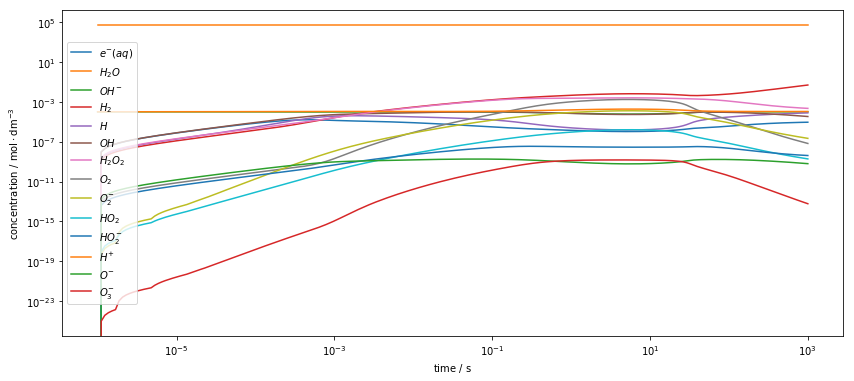

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
cvode_sys.plot_result(tout, *cvode_sys.integrate(tout, y0), ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')